In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
import matlab.engine as engi
import matlab as mat
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import SMOTE
from sklearn.preprocessing import MinMaxScaler
import CFS
import metrices
import pickle

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt

In [25]:
def load_data(project):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    commit_guru_path = 'data/commit_guru/' + project + '.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
#     print(cols_list)
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    
    commit_guru_df = commit_guru_df.drop(labels = ['parent_hashes','author_name','author_name',
                                                   'author_email','fileschanged','author_date',
                                                   'author_date_unix_timestamp', 'commit_message',
                                                  'classification', 'fix', 'contains_bug','fixes',],axis=1)

#     print(commit_guru_df.columns)
    understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    df = understand_df.merge(commit_guru_df,on='commit_hash')
    cols = df.columns.tolist()
    cols = cols[1:] + [cols[0]]
    df = df[cols]
    for item in ['Kind', 'Name','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
#     df,cols = apply_cfs(df)
    y = df.Bugs
    X = df.drop('Bugs',axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    return X,y
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

In [84]:
def run_self(project):
    X,y = load_data(project)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=18)
    df_smote = pd.concat([X_train,y_train],axis = 1)
    df_smote = apply_smote(df_smote)
    y_train = df_smote.Bugs
    X_train = df_smote.drop('Bugs',axis = 1)
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    abcd = metrices.measures(y_test,predicted)
    pf = abcd.get_pf()
    recall = abcd.calculate_recall()
    precision = abcd.calculate_precision()
    f1 = abcd.calculate_f1_score()
    g_score = abcd.get_g_score()
    auc = roc_auc_score(y_test, predicted)
    print(classification_report(y_test, predicted))
    return recall,precision,pf,f1,g_score,auc

In [30]:
# _dir = 'data/understand_files/'
# projects = [f.split('_understand')[0] for f in listdir(_dir) if isfile(join(_dir, f))]

In [85]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()

In [90]:
precision_list = {}
recall_list = {}
pf_list = {}
f1_list = {}
g_list = {}
auc_list = {}
for project in projects:
    try:
        if project == '.DS_Store':
            continue
    #     if project != 'guice':
    #         continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        recall,precision,pf,f1,g_score,auc = run_self(project)
        recall_list[project] = recall
        precision_list[project] = precision
        pf_list[project] = pf
        f1_list[project] = f1
        g_list[project] = g_score
        auc_list[project] = auc
    except Exception as e:
        print(e)
        continue
final_result = {}
final_result['precision'] = precision_list
final_result['recall'] = recall_list
final_result['pf'] = pf_list
final_result['f1'] = f1_list
final_result['g'] = g_list
final_result['auc'] = auc_list
with open('data/self_100.pkl', 'wb') as handle:
    pickle.dump(final_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

+++++++++++++++++   Android-ObservableScrollView  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       187
           1       0.44      0.59      0.50        74

    accuracy                           0.67       261
   macro avg       0.62      0.64      0.63       261
weighted avg       0.71      0.67      0.68       261

+++++++++++++++++   picasso  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       328
           1       0.75      0.74      0.75       338

    accuracy                           0.75       666
   macro avg       0.75      0.75      0.75       666
weighted avg       0.75      0.75      0.75       666

+++++++++++++++++   Telegram  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4952
           1       0.67      0.81      0.74      2118

    accuracy       

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.50      0.50      0.50        12

    accuracy                           0.71        42
   macro avg       0.65      0.65      0.65        42
weighted avg       0.71      0.71      0.71        42

+++++++++++++++++   react-native-background-job  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.50      0.25      0.33        12

    accuracy                           0.54        26
   macro avg       0.53      0.52      0.49        26
weighted avg       0.53      0.54      0.50        26

+++++++++++++++++   easygcm  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.73      0.85        15

    accuracy                           0.83        24
   macro avg  

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        32
           1       0.72      0.79      0.75        29

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61

+++++++++++++++++   MaterialScrollBar  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        57
           1       0.65      0.73      0.69        45

    accuracy                           0.71       102
   macro avg       0.71      0.71      0.70       102
weighted avg       0.71      0.71      0.71       102

+++++++++++++++++   fragmentargs  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.09      0.20      0.13         5
           1       0.76      0.57      0.65        23

    accuracy                           0.50        28
   macro avg       

              precision    recall  f1-score   support

           0       0.83      0.76      0.80       229
           1       0.70      0.78      0.74       161

    accuracy                           0.77       390
   macro avg       0.76      0.77      0.77       390
weighted avg       0.78      0.77      0.77       390

+++++++++++++++++   manifold  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       515
           1       0.62      0.58      0.60       409

    accuracy                           0.66       924
   macro avg       0.65      0.65      0.65       924
weighted avg       0.66      0.66      0.66       924

+++++++++++++++++   Elephant  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       350
           1       0.62      0.74      0.67       200

    accuracy                           0.74       550
   macro avg       0.72      0.7

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       619
           1       0.68      0.62      0.65       487

    accuracy                           0.70      1106
   macro avg       0.70      0.69      0.70      1106
weighted avg       0.70      0.70      0.70      1106

+++++++++++++++++   jBrowserDriver  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       402
           1       0.77      0.77      0.77       371

    accuracy                           0.78       773
   macro avg       0.78      0.78      0.78       773
weighted avg       0.78      0.78      0.78       773

+++++++++++++++++   BiglyBT  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3960
           1       0.64      0.66      0.65      1568

    accuracy                           0.80      5528
   macro avg       0.75    

              precision    recall  f1-score   support

           0       0.55      0.59      0.57       856
           1       0.70      0.68      0.69      1243

    accuracy                           0.64      2099
   macro avg       0.63      0.63      0.63      2099
weighted avg       0.64      0.64      0.64      2099

+++++++++++++++++   Discord4J  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       886
           1       0.78      0.67      0.72      1448

    accuracy                           0.68      2334
   macro avg       0.68      0.69      0.67      2334
weighted avg       0.70      0.68      0.69      2334

+++++++++++++++++   OpenRefine  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1784
           1       0.70      0.73      0.72      1577

    accuracy                           0.73      3361
   macro avg       0.73      

0.7058823529411765 0.72 0.24 0.71 0.73 0.7363328495403968


Text(0.5, 1.0, 'auc')

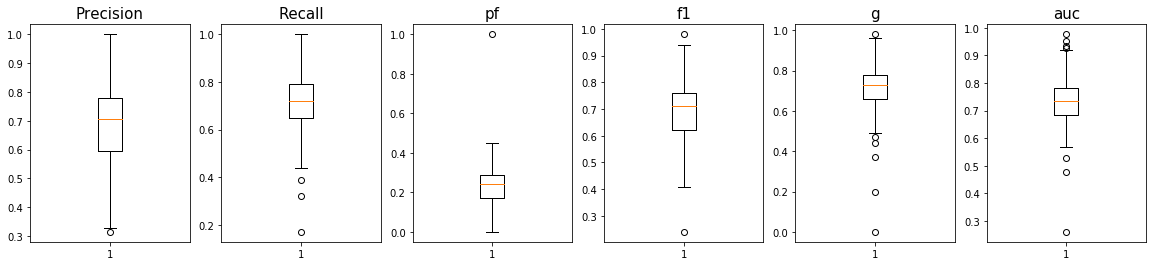

In [34]:
_precision = list(precision_list.values())
_recall = list(recall_list.values())
_pf = list(pf_list.values())
_f1 = list(f1_list.values())
_g = list(g_list.values())
_auc = list(auc_list.values())
print(np.median(_precision),np.median(_recall),np.median(_pf),np.median(_f1),np.median(_g),np.median(_auc))
fig = plt.figure(num=None, figsize = (20,4), facecolor='w', edgecolor='k')
ax = fig.add_subplot(161)
ax.boxplot(_precision)
ax.set_title('Precision',size = 15)
ax = fig.add_subplot(162)
ax.boxplot(_recall)
ax.set_title('Recall',size = 15)
ax = fig.add_subplot(163)
ax.boxplot(_pf)
ax.set_title('pf',size = 15)
ax = fig.add_subplot(164)
ax.boxplot(_f1)
ax.set_title('f1',size = 15)
ax = fig.add_subplot(165)
ax.boxplot(_g)
ax.set_title('g',size = 15)
ax = fig.add_subplot(166)
ax.boxplot(_auc)
ax.set_title('auc',size = 15)
# fig.savefig('without_process.png')

In [40]:
def run_self(project):
    X,y = load_data(project)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=18)
    df_smote = pd.concat([X_train,y_train],axis = 1)
    df_smote = apply_smote(df_smote)
    y_train = df_smote.Bugs
    X_train = df_smote.drop('Bugs',axis = 1)
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    return clf

In [75]:
precision_list = {}
recall_list = {}
pf_list = {}
f1_list = {}
g_list = {}
auc_list = {}
for s_project in projects:
    try:
        if project == '.DS_Store':
            continue
    #     if project != 'guice':
    #         continue
        print("+++++++++++++++++   "  + s_project + "  +++++++++++++++++")
        clf = run_self(s_project)
        if s_project not in precision_list.keys():
            precision_list[s_project] = {}
            recall_list[s_project] = {}
            pf_list[s_project] = {}
            f1_list[s_project] = {}
            g_list[s_project] = {}
            auc_list[s_project] = {}    
        for d_project in projects:
            try:
                X,y = load_data(d_project)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=18)
                predicted = clf.predict(X_test)
                abcd = metrices.measures(y_test,predicted)
                pf = abcd.get_pf()
                recall = abcd.calculate_recall()
                precision = abcd.calculate_precision()
                f1 = abcd.calculate_f1_score()
                g_score = abcd.get_g_score()
                auc = roc_auc_score(y_test, predicted)
                precision_list[s_project][d_project] = precision
                recall_list[s_project][d_project] = recall
                pf_list[s_project][d_project] = pf
                f1_list[s_project][d_project] = f1
                g_list[s_project][d_project] = g_score
                auc_list[s_project][d_project] = auc
            except Exception as e:
                print('d_project',e)
                continue
    except Exception as e:
        print('s_project',e)
        continue
final_result = {}
final_result['precision'] = precision_list
final_result['recall'] = recall_list
final_result['pf'] = pf_list
final_result['f1'] = f1_list
final_result['g'] = g_list
final_result['auc'] = auc_list
with open('data/conv_bellwether_100.pkl', 'wb') as handle:
    pickle.dump(final_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

+++++++++++++++++   Android-ObservableScrollView  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   picasso  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   Telegram  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defi

d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   react-native-background-job  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   easygcm  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   ion-java  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defin

d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   fragmentargs  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   freeline  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   postgres-async-driver  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not define

+++++++++++++++++   metacat  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   subclipse  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   couchdb-lucene  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that c

d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   amidst  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   jsweet  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_project 'commit_hash'
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
+++++++++++++++++   pgjdbc-ng  +++++++++++++++++
d_project Only one class present in y_true. ROC AUC score is not defined in that case.
d_pr

In [74]:
np.median(list(final_result['precision']['Android-ObservableScrollView'].values()))

0.57

In [72]:
list(final_result['precision']['Android-ObservableScrollView'].values())

[0.45,
 0.65,
 0.43,
 0.57,
 0.71,
 0.28,
 0.37,
 0.34,
 0.53,
 0.53,
 0.6,
 0.49,
 0.5,
 0.18,
 0.83]

In [73]:
(precision_list)

{'Android-ObservableScrollView': {'Android-ObservableScrollView': 0.48,
  'picasso': 0.69,
  'Telegram': 0.45,
  'springside4': 0.58,
  'disruptor': 0.69,
  'ActionBarSherlock': 0.29,
  'roboguice': 0.37,
  'Hystrix': 0.35,
  'facebook-android-sdk': 0.54,
  'jsoup': 0.52,
  'AndroidAsync': 0.61,
  'metrics': 0.51,
  'androidannotations': 0.51,
  'druid': 0.28,
  'org.alloytools.alloy': 0.82,
  'android-ago': 0.5,
  'project-rome': 0.46,
  'sqlite-android': 0.12,
  'SuperListview': 0.42,
  'scoop': 0.21,
  'android-transcoder': 0.5,
  'dcevm': 0.61,
  'progressbar': 0.7,
  'moditect': 0.14,
  'clean-status-bar': 0.38,
  'react-native-background-job': 0.55,
  'easygcm': 0.8,
  'ion-java': 0.54,
  'SoLoader': 0.26,
  'UpdateChecker': 0.53,
  'arara': 0.82,
  'swipe-button': 0.5,
  'DaggerMock': 0.26,
  'react-native-dialogs': 0.69,
  'sofa-tracer': 0.34,
  'spring-javaformat': 0.47,
  'JSONassert': 0.38,
  'pacbot': 0.14,
  'eo': 0.68,
  'RxJavaFX': 0.41,
  'android-test': 0.63,
  'react-

In [99]:
df_self = pd.read_pickle('data/self_100.pkl')
df_bellwether = pd.read_pickle('data/conv_bellwether_100.pkl')
metrices = df_self.keys()
median = 0
for s_project in projects:
    try:
        print("+++++++++++++++++++++++++++++",s_project,"+++++++++++++++++++++++++++++++")
        for metric in metrices:
            print("-------",metric,":")
            print("Bellwether",np.median(list(df_bellwether[metric][s_project].values())))
            print("Self",df_self[metric][s_project])
    except ValueError:
        print(s_project)
        continue

+++++++++++++++++++++++++++++ Android-ObservableScrollView +++++++++++++++++++++++++++++++
------- precision :
Bellwether 0.56
Self 0.44
------- recall :
Bellwether 0.445
Self 0.59
------- pf :
Bellwether 0.29
Self 0.3
------- f1 :
Bellwether 0.485
Self 0.5
------- g :
Bellwether 0.475
Self 0.61
------- auc :
Bellwether 0.5842193356773304
Self 0.6448908801849979
+++++++++++++++++++++++++++++ picasso +++++++++++++++++++++++++++++++
------- precision :
Bellwether 0.58
Self 0.75
------- recall :
Bellwether 0.545
Self 0.74
------- pf :
Bellwether 0.3
Self 0.25
------- f1 :
Bellwether 0.535
Self 0.75
------- g :
Bellwether 0.55
Self 0.74
------- auc :
Bellwether 0.6171330639395627
Self 0.7463017751479291
+++++++++++++++++++++++++++++ Telegram +++++++++++++++++++++++++++++++
------- precision :
Bellwether 0.605
Self 0.67
------- recall :
Bellwether 0.47
Self 0.81
------- pf :
Bellwether 0.23
Self 0.17
------- f1 :
Bellwether 0.53
Self 0.74
------- g :
Bellwether 0.49
Self 0.81
------- auc :


KeyError: 'qpython'

In [92]:
df_self

{'precision': {'Android-ObservableScrollView': 0.44,
  'picasso': 0.75,
  'Telegram': 0.67,
  'springside4': 0.74,
  'disruptor': 0.75,
  'ActionBarSherlock': 0.43,
  'roboguice': 0.49,
  'Hystrix': 0.52,
  'facebook-android-sdk': 0.58,
  'jsoup': 0.72,
  'AndroidAsync': 0.68,
  'metrics': 0.58,
  'androidannotations': 0.73,
  'druid': 0.59,
  'org.alloytools.alloy': 0.9,
  'project-rome': 0.75,
  'sqlite-android': 0.36,
  'SuperListview': 0.5,
  'scoop': 0.48,
  'android-transcoder': 0.67,
  'dcevm': 0.87,
  'progressbar': 0.82,
  'moditect': 0.3,
  'clean-status-bar': 0.5,
  'react-native-background-job': 0.5,
  'easygcm': 1.0,
  'ion-java': 0.76,
  'SoLoader': 0.45,
  'UpdateChecker': 0.56,
  'arara': 0.96,
  'swipe-button': 0.78,
  'DaggerMock': 0.43,
  'react-native-dialogs': 0.88,
  'sofa-tracer': 0.52,
  'spring-javaformat': 0.72,
  'JSONassert': 0.6,
  'pacbot': 0.36,
  'eo': 0.78,
  'RxJavaFX': 0.6,
  'android-test': 0.76,
  'react-native-sensitive-info': 0.91,
  'loklak_wok_a